## Решение задачи регрессии с помощью нейронных сетей

Определение стоимости недвижимости из набора данных [California Housing Data Set](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

Учебный курс "[Программирование глубоких нейронных сетей на Python](https://openedu.ru/course/urfu/PYDNN/)".

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
""" посмотрим, какие файлы храняться в директории """
import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dl-urfu-regression/sample_submission.csv
/kaggle/input/dl-urfu-regression/train.csv
/kaggle/input/dl-urfu-regression/test.csv


## Загружаем данные

In [2]:
train_df = pd.read_csv('/kaggle/input/dl-urfu-regression/train.csv')
test_df = pd.read_csv('/kaggle/input/dl-urfu-regression/test.csv')
sample_submission = pd.read_csv('/kaggle/input/dl-urfu-regression/sample_submission.csv', index_col='id')

**Описание данных**

California Housing содержит данные о средней стоимость домов в Калифорнии для квартала. Файл с данными содержит следующие столбцы:

*   **longitude** - долгота квартала с недвижимостью.
*   **latitude** - широта квартала с недвижимостью.
*   **housing_median_age** - медиана возраста домов в квартале.
*   **total_rooms** - общее колиичество комнат в квартале.
*   **total_bedrooms** - общее количество спален в квартале.
*   **population** - население квартала.
*   **households** - количество "домохозяйств" в квартале (групп людей живущих вместе в одном доме. Как правило это семьи).
*   **median_income** - медианный доход в квартале.
*   **median_house_value** - медианная стоимость дома в квартале.



In [3]:
"""Смотрим на случайные 3 записи в нашем тренировочном наборе"""
train_df.sample(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
6860,-120.10,36.96,20.0,2100.0,317.0,910.0,274.0,4.8187,90900.0
9146,-122.12,37.75,28.0,794.0,111.0,329.0,109.0,7.6923,329800.0
13893,-118.13,33.97,36.0,1759.0,295.0,837.0,267.0,4.6992,251900.0


In [4]:
"""Смотрим на случайные 3 записи в нашем тестовом наборе"""
test_df.sample(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
22,-116.31,33.66,7.0,4497.0,831.0,2248.0,713.0,3.6354
65,-116.95,32.84,31.0,1307.0,245.0,752.0,231.0,3.4286
712,-118.09,33.82,36.0,2219.0,393.0,1042.0,396.0,5.2299


In [5]:
"""Смотрим на случайные 3 записи в шаблоне для ответов"""
sample_submission.sample(3)

,median_house_value
id,
1165,0.1165
2313,0.2313
942,0.9420


## Постановка задачи регрессии

Необходимо определить медианную стоимость дома в квартале, зная все остальные признаки.

**Целевая переменная**: `median_house_value`

**Признаки**: `longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households,	median_income`

Признаки подаются на вход нейронной сети, на выходе сеть должна выдать значение целевой переменной - `median_house_value`

In [6]:
"""Выделяем данные для обучения и преобразуем их в массивы numpy.
Функция pop() возвращает нам указанный столбец и одновременно удаляет его из таблицы.
Таким образом, когда мы присваиваем df_train в переменную x_train,
там уже нет столбца с метками правильных ответов median_house_value """
y_train = train_df.pop('median_house_value').values
x_train = train_df.values
x_test = test_df.values

In [7]:
"""Убедимся, что количество столбцов в данных совпадает"""
x_train.shape, x_test.shape

((17000, 8), (3000, 8))

**Стандартизация данных**

Вычитаем среднее значение и делим на стандартное отклонение

In [8]:
# Среднее значение
mean = x_train.mean(axis=0)
# Стандартное отклонение
std = x_train.std(axis=0)
x_train -= mean
x_train /= std
x_test -= mean
x_test /= std

## Создаем нейронную сеть

Выходной слой с одним линейным нейроном - для задачи регрессии функция активации - RELU.

In [9]:
model = Sequential()
model.add(Dense(260, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(150, activation='relu'))
model.add(Dense(90, activation='relu'))
model.add(Dense(45, activation='relu'))
model.add(Dense(1, activation='relu'))

In [10]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 260)               2340      
_________________________________________________________________
dense_1 (Dense)              (None, 150)               39150     
_________________________________________________________________
dense_2 (Dense)              (None, 90)                13590     
_________________________________________________________________
dense_3 (Dense)              (None, 45)                4095      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 46        
Total params: 59,221
Trainable params: 59,221
Non-trainable params: 0
_________________________________________________________________
None


**Компилируем сеть**

Функция ошибки - среднеквадратичное отклонение. Метрика - среднее абсолютное отклонение.

In [11]:
model.compile(optimizer='nadam', loss='mape', metrics=['mae'])

## Обучаем нейронную сеть

In [12]:
history = model.fit(x_train, 
                    y_train,
                    batch_size=20, 
                    epochs=100, 
                    validation_split=0.1, 
                    verbose=2)

Epoch 1/100
765/765 - 3s - loss: 46.0019 - mae: 99425.5391 - val_loss: 25.5840 - val_mae: 55689.5312
Epoch 2/100
765/765 - 1s - loss: 24.6885 - mae: 51990.3906 - val_loss: 22.9542 - val_mae: 48858.0391
Epoch 3/100
765/765 - 1s - loss: 23.3313 - mae: 48911.7031 - val_loss: 22.3482 - val_mae: 47827.0625
Epoch 4/100
765/765 - 2s - loss: 22.9721 - mae: 48118.5391 - val_loss: 22.2614 - val_mae: 46994.3945
Epoch 5/100
765/765 - 1s - loss: 22.7384 - mae: 47578.3086 - val_loss: 22.1193 - val_mae: 48567.0625
Epoch 6/100
765/765 - 1s - loss: 22.5267 - mae: 47306.8672 - val_loss: 22.1699 - val_mae: 46276.2070
Epoch 7/100
765/765 - 1s - loss: 22.4354 - mae: 47098.8281 - val_loss: 22.0176 - val_mae: 48089.3594
Epoch 8/100
765/765 - 2s - loss: 22.3146 - mae: 46792.8555 - val_loss: 21.7534 - val_mae: 46772.9219
Epoch 9/100
765/765 - 1s - loss: 22.2520 - mae: 46652.4023 - val_loss: 21.6952 - val_mae: 46378.1211
Epoch 10/100
765/765 - 2s - loss: 22.1661 - mae: 46487.4453 - val_loss: 21.5889 - val_mae: 

## Визуализация качества обучения

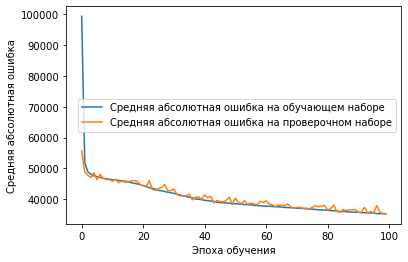

In [13]:
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

## Готовим данные для теста на liderboard

Делаем предсказания на тестовом наборе данных

In [14]:
"""делаем предсказания по всем тестовым данным"""
predictions = model.predict(x_test)
predictions

array([[ 50730.906],
       [ 74135.67 ],
       [ 64239.74 ],
       ...,
       [306443.97 ],
       [ 63474.285],
       [ 74649.69 ]], dtype=float32)

Пишем результаты предсказаний в шаблон "sample_submission"

In [15]:
"""используем файл с правильным шаблоном формата записи ответов и пишем в него наши предсказания"""
sample_submission['median_house_value'] = predictions

Записываем ответы для проверки на liderboard

In [16]:
"""to_csv - пишет табличные данные в файл '.csv' """
sample_submission.to_csv('sample_submission.csv')